# Feature selection

This content is mainly based on the following scikit learn documentations:

- [Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [Model-based and sequential feature selection](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py) from Manoj Kumar, Maria Telenczuk and Nicolas Hug.
- [Common pitfalls in the interpretation of coefficients of linear models](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py)

## Import data

In [15]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/kirenz/datasets/master/happiness_report.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              157 non-null    int64  
 1   country         157 non-null    object 
 2   happiness       157 non-null    float64
 3   gdp             157 non-null    float64
 4   family          157 non-null    float64
 5   lifeexpectancy  157 non-null    float64
 6   trust           157 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.7+ KB


In [16]:
# reset index
df.set_index('country', inplace=True)

In [17]:
# show data
df

,id,happiness,gdp,family,lifeexpectancy,trust
country,,,,,,
Denmark,1,7.526,1.44178,1.16374,0.79504,0.44453
Switzerland,2,7.509,1.52733,1.14524,0.86303,0.41203
Iceland,3,7.501,1.42666,1.18326,0.86733,0.14975
Norway,4,7.498,1.57744,1.12690,0.79579,0.35776
Finland,5,7.413,1.40598,1.13464,0.81091,0.41004
...,...,...,...,...,...,...
Benin,153,3.484,0.39499,0.10419,0.21028,0.06681
Afghanistan,154,3.360,0.38227,0.11037,0.17344,0.07112
Togo,155,3.303,0.28123,0.00000,0.24811,0.11587


## Data preprocessing & exploration

In [18]:
# prepare data for scikit learn models
feature_names = ['gdp', 'family', 'lifeexpectancy', 'trust']

X = df[feature_names]
y = df['happiness']

- We split the sample into a train and a test dataset. 
- Only the train dataset will be used in the following exploratory analysis. 
- This is a way to emulate a real situation where predictions are performed on an unknown target, and we don’t want our analysis and decisions to be biased by our knowledge of the test data.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

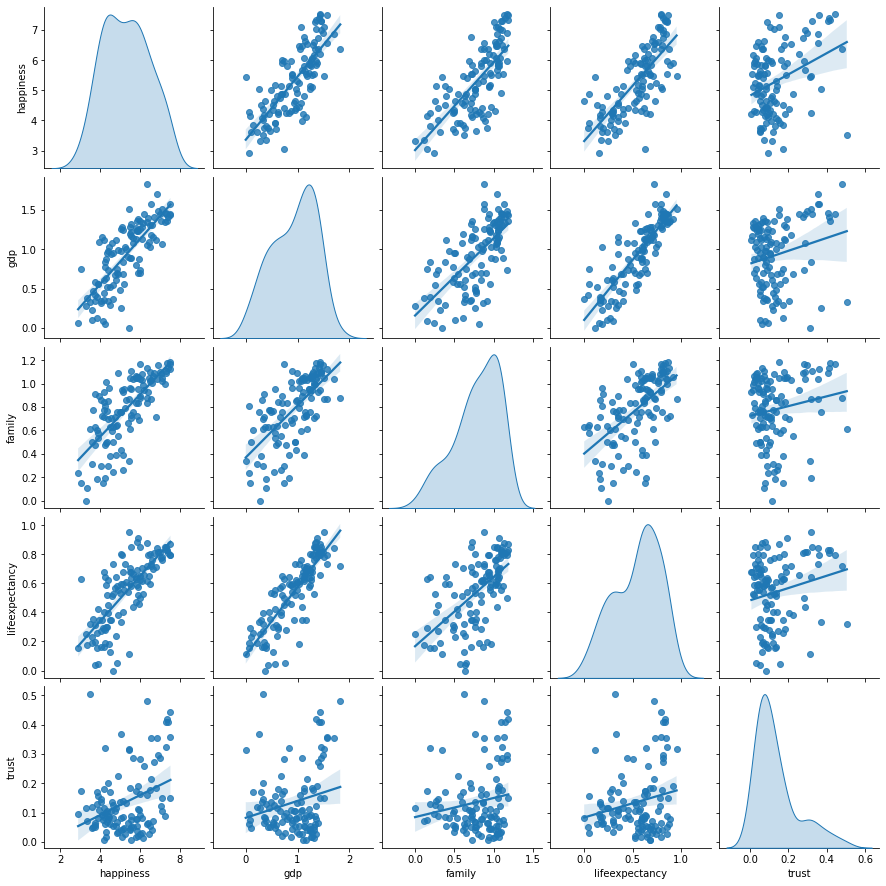

In [20]:
# explore data
import seaborn as sns

train_dataset = X_train.copy()
train_dataset.insert(0, "happiness", y_train)

sns.pairplot(train_dataset, kind="reg", diag_kind="kde");

## Model

We fit a lasso regression with 5-fold cross validation to choose the best regularization parameter based on the mean squared error:

In [21]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5, random_state=10).fit(X_train, y_train)

In [22]:
# show best alpha parameter
lasso.alpha_

0.0013272714416684127

Show feature importance plot

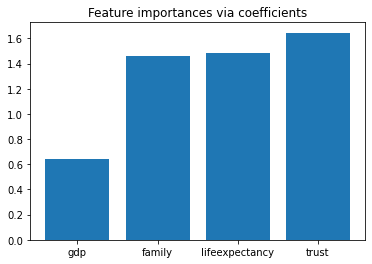

In [33]:
import matplotlib.pyplot as plt
import numpy as np

importance = np.abs(lasso.coef_)
feature_names = np.array(feature_names)

plt.bar(height=importance, x=feature_names)

plt.title("Feature importances via coefficients")
plt.show()

## Feature selection

### Based on importance

We want to select the two features which are the most important according to the coefficients. The SelectFromModel is meant just for that. SelectFromModel accepts a threshold parameter and will select the features whose importance (defined by the coefficients) are above this threshold.

In our case, we want to select only 2 features. Hence, we will set the threshold slightly above the coefficient of the third most important feature. 

We also record the time the algorithm takes to obtain the results.

In [24]:
from sklearn.feature_selection import SelectFromModel
from time import time

# set threshold
threshold = np.sort(importance)[-3] + 0.01

# obtain time
tic = time()

# fit model
sfm = SelectFromModel(lasso, threshold=threshold).fit(X, y)

# obtain time
toc = time()

# print results
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['family' 'lifeexpectancy' 'trust']
Done in 0.038s


### Sequential Feature Selection (SFS)

Another way of selecting features is to use SequentialFeatureSelector (SFS). SFS is a greedy procedure where, at each iteration, we choose the best new feature to add to our selected features based a cross-validation score. 

- `Forward-Selection`: That is, we start with 0 features and choose the best single feature with the highest score. The procedure is repeated until we reach the desired number of selected features.

- `Backward selection`: We can also go in the reverse direction (backward SFS), i.e. start with all the features and greedily choose features to remove one by one. We illustrate both approaches here.



#### Forward selection

In [25]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()

sfs_forward = SequentialFeatureSelector(
    lasso, n_features_to_select=2, direction="forward"
).fit(X, y)

toc_fwd = time()

In [26]:
print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Features selected by forward sequential selection: ['gdp' 'family']
Done in 1.169s


#### Backward selection

In [27]:
tic_bwd = time()

sfs_backward = SequentialFeatureSelector(
    lasso, n_features_to_select=2, direction="backward"
).fit(X, y)

toc_bwd = time()

In [28]:
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by backward sequential selection: ['family' 'lifeexpectancy']
Done in 1.164s


## Discussion

To finish with, we should note that 

- SelectFromModel is significantly faster than SFS (SelectFromModel only needs to fit a model once, while SFS needs to cross-validate many different models for each of the iterations)

- SFS however works with any model, while SelectFromModel requires the underlying estimator to expose a coef_ attribute or a feature_importances_ attribute. 

- The forward SFS is faster than the backward SFS because it only needs to perform n_features_to_select = 2 iterations, while the backward SFS needs to perform n_features - n_features_to_select.